In [22]:
import matplotlib.pyplot as plt
from matplotlib import style

from tpelm import *
from tpelm.bspline import BSpline
from tpelm.tensor_grid import TensorGrid
from tpelm.magnetostatic import DomainState, solve_energy, fit_mag

from sources import m_uniform, flower_state, vortex_state

jax.config.update("jax_enable_x64", True)

# Higher order stray field magnetostatic energy computation

In this notebook, the higher order stray field method is used for magnetostatic energy
computation. 

First we define the `setup` and the `solve` function. `setup` initializes a solver for the respective domain and computes factor matrices to solve the superpotential. The `solve` function computes the
magnetostatic energy. We use the same TPELM for superpotential and magnetization ($r_p=r_p'$) but note that for easy magnetizations (e.g. flower state) we could use a much smaller rank $r'$ which would speed up the computation drastically.

In [2]:
s = 46


def setup(mag, model: BSpline, target_tg: TensorGrid):
    state = DomainState.init(
        sp_elm=model,
        sp_quad_grid=target_tg,
        mag_quad_grid=target_tg,
        target_quad_grid=target_tg,
        gs_terms=s,
        gk_max_ninter=100
    )
    mag = fit_mag(state, mag)  # prefit magnetization to functional Tucker format
    return state, mag

@jax.jit
def solve(state: DomainState, mag) -> jax.Array:
    return solve_energy(state, mag)


## Energy for a uniformly magnetized cube

We solve the energy for a uniform magnetization within the unit cube. Theoretically we could set $r'=1$ with $k'=0$ to perfectly fit the magnetization, but we use a much larger rank here for demonstration.

The energy is computed for different ranks $r$ and different B-spline orders $k$. The number of exponential sum terms $S=46$ is used. All fitting procedures use 250 Gauss-Legendre quadrature points for each dimension. This could also be done per spline segment instead to improve accuracy.

In [ ]:
target_tg = TensorGrid(*[jnp.array([-0.5, 0.5])] * 3).to_gauss(250)

# uniform state
e_true = 1 / 6
for k in [3, 4, 5, 6, 7]:
    for r in [10, 20, 40, 80]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(m_uniform, model, target_tg)
        e = solve(solver, mag).block_until_ready()
        err = jnp.abs(e - e_true)
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, error={err:.4e}, fitting_time={t.average * 1000:.3f} ms")

k=4, r=10, energy=1.620793e-01 error=4.5874e-03, fitting_time=14.262 ms
k=4, r=20, energy=1.654046e-01 error=1.2621e-03, fitting_time=21.198 ms
k=4, r=40, energy=1.663744e-01 error=2.9222e-04, fitting_time=50.350 ms
k=4, r=80, energy=1.666181e-01 error=4.8537e-05, fitting_time=447.040 ms
k=5, r=10, energy=1.669192e-01 error=2.5257e-04, fitting_time=14.447 ms
k=5, r=20, energy=1.669199e-01 error=2.5323e-04, fitting_time=21.528 ms
k=5, r=40, energy=1.667689e-01 error=1.0222e-04, fitting_time=50.054 ms
k=5, r=80, energy=1.666947e-01 error=2.8009e-05, fitting_time=446.407 ms
k=6, r=10, energy=1.669119e-01 error=2.4528e-04, fitting_time=14.777 ms
k=6, r=20, energy=1.667239e-01 error=5.7207e-05, fitting_time=19.629 ms
k=6, r=40, energy=1.666794e-01 error=1.2754e-05, fitting_time=53.153 ms
k=6, r=80, energy=1.666514e-01 error=1.5248e-05, fitting_time=450.329 ms
k=7, r=10, energy=1.666988e-01 error=3.2176e-05, fitting_time=15.270 ms
k=7, r=20, energy=1.666763e-01 error=9.5961e-06, fitting_time

In [4]:
k = 7
rs = [10, 15, 20, 25, 30, 35, 40]
energies = []

for r in rs:
    grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
    model = BSpline(grid, degree=k - 1)
    solver, mag = setup(m_uniform, model, target_tg)
    e = solve(solver, mag)
    energies.append(e)
    

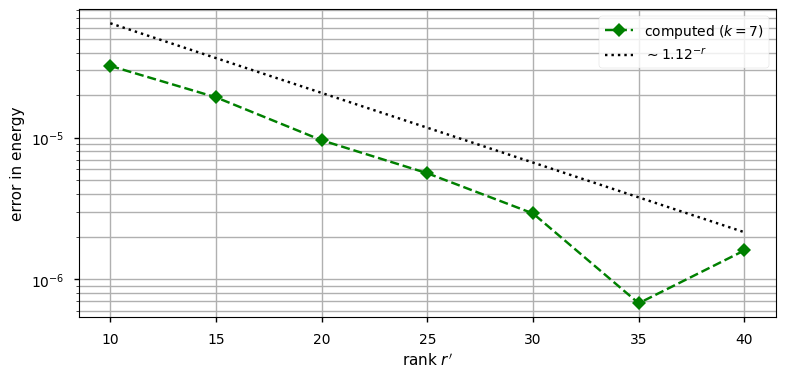

In [47]:
with style.context("seaborn-v0_8-notebook"):
    plt.figure(figsize=(9, 4))
    plt.plot(rs, [jnp.abs(e - 1 / 6) for e in energies], "--D", color="green", label="computed ($k=7$)")
    plt.plot(rs, [2e-4 * 1.12 ** (-r) for r in rs], ":", color="k", label=r"$\sim 1.12^{-r}$")
    plt.xlabel("rank $r'$")
    plt.ylabel("error in energy")
    plt.yscale("log")
    plt.grid(axis="x")
    plt.grid(axis="y", which="both")
    plt.legend()

## Energy for flower and vortex state

The same energy computation with the same setup is done for a flower and vortex state in the unit cube.

### Flower state:

In [ ]:
from collections import defaultdict

energies_flower = defaultdict(dict)
# flower state
for k in [4, 5, 6, 7, 8, 9]:
    for r in [10, 20, 30, 40, 50, 60, 70, 80]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(flower_state, model, target_tg)
        e = solve(solver, mag).block_until_ready()
        energies_flower[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")

k=4, r=10, energy=1.481198e-01, fitting_time=11.200 ms
k=4, r=20, energy=1.515203e-01, fitting_time=15.878 ms
k=4, r=30, energy=1.522469e-01, fitting_time=25.923 ms
k=4, r=40, energy=1.525044e-01, fitting_time=47.187 ms
k=4, r=50, energy=1.526270e-01, fitting_time=74.991 ms
k=4, r=60, energy=1.526952e-01, fitting_time=126.129 ms
k=4, r=70, energy=1.527253e-01, fitting_time=290.272 ms
k=4, r=80, energy=1.527512e-01, fitting_time=454.395 ms
k=5, r=10, energy=1.530675e-01, fitting_time=13.773 ms
k=5, r=20, energy=1.530601e-01, fitting_time=15.935 ms
k=5, r=30, energy=1.529580e-01, fitting_time=34.025 ms
k=5, r=40, energy=1.529051e-01, fitting_time=49.645 ms
k=5, r=50, energy=1.528746e-01, fitting_time=79.909 ms
k=5, r=60, energy=1.528549e-01, fitting_time=123.717 ms
k=5, r=70, energy=1.528406e-01, fitting_time=310.396 ms
k=5, r=80, energy=1.528294e-01, fitting_time=449.695 ms
k=6, r=10, energy=1.530650e-01, fitting_time=12.321 ms
k=6, r=20, energy=1.528629e-01, fitting_time=16.601 ms
k=6,

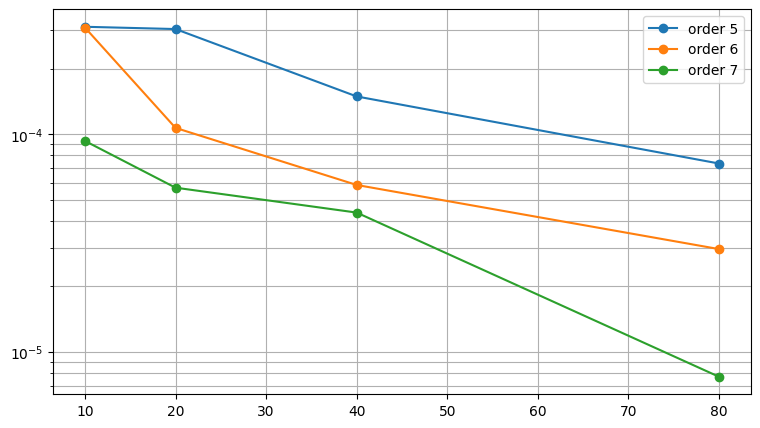

In [87]:
e_true_flower = 0.152756
plt.figure(figsize=(9, 5))
#for k in energies_flower.keys():
for k in [5, 6, 7]:
    r, e = zip(*energies_flower[k].items())
    plt.plot(r, [abs(_e - e_true_flower) for _e in e], "-o", label = f"order {k}")
    
plt.yscale("log")
plt.grid(which="both")
plt.legend()

### Vortex state:

In [ ]:
energies_vortex = defaultdict(dict)

# vortex state
for k in [4, 5, 6, 7]:
    for r in [10, 20, 40, 80]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(vortex_state, model, target_tg)
        e = solve(solver, mag).block_until_ready()
        energies_vortex[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")

## Vortex state in a thin film

For other domains, such as a thin film $[-0.5, 0.5]\times [-0.5, 0.5] \times [-0.05, 0.05]$ we need to adjust the spline model and the quadrature tensor grid. As a reference we have $e_d=0.001562$ computed by *mumax3*.

In [ ]:
# thin film
energies_thin_film = defaultdict(dict)

target_tg = TensorGrid(
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.05, 0.05]),
).to_gauss((250, 250, 50))


for k in [4, 5, 6, 7, 8]:
    for r in [20, 40, 60]:
        grid = TensorGrid(
            jnp.linspace(-0.5, 0.5, r),
            jnp.linspace(-0.5, 0.5, r),
            jnp.linspace(-0.05, 0.05, r // 4)
        )
        model = BSpline(grid, degree=k - 1)
        solver, mag = setup(vortex_state, model, target_tg)
        e = solve(solver, mag).block_until_ready()
        energies_thin_film[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")